# Introduction
A very important aspect of supervised and semi-supervised machine learning is the quality of the labels produced by human labelers. Unfortunately, humans are not perfect and in some cases may even maliciously label things incorrectly. In this assignment, you will evaluate the impact of incorrect labels on a number of different classifiers.

We have provided a number of code snippets you can use during this assignment. Feel free to modify them or replace them.


## Dataset
The dataset you will be using is the [Adult Income dataset](https://archive.ics.uci.edu/ml/datasets/Adult). This dataset was created by Ronny Kohavi and Barry Becker and was used to predict whether a person's income is more/less than 50k USD based on census data.

### Data preprocessing
Start by loading and preprocessing the data. Remove NaN values, convert strings to categorical variables and encode the target variable (the string <=50K, >50K in column index 14).

In [22]:
import random
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import minmax_scale

from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import confusion_matrix, accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:

INFO = False


In [3]:

class DataSet():
	def __init__(self, x, y):
		self.X = x
		self.y = y


In [4]:

# This can be used to load the dataset
def load_clean_data():
    data = pd.read_csv("./adult.csv", header=0, na_values='?')

    if INFO:
        print( data.shape )
        print( data.columns )

    # Check for overly empty feature columns
    for column in data.columns:
        nans = data[column].isna()
        if nans.sum() >= 0.6*data.shape[0]:
            print( f"Dropping {column}" )
            data.drop( column )

    # Drop any rows with NaN
    # Try imputation
    data.dropna( inplace=True )
    

    # Capital loss and capital gain represent essentially the exact same information
    # Capital delta can represent both at the same time without increasing dimensionality
    data['capital-delta'] = data['capital-gain'] - data['capital-loss']

    
    # Education is the same as education-num if it were ordinally encoded.
    # Capital loss/gain already encoded with capital delta
    data.drop( columns=[ 'education', 'capital-gain', 'capital-loss' ], inplace=True )
    
    if INFO:
        print( data.shape )

    return data


### Data classification
Choose at least 4 different classifiers and evaluate their performance in predicting the target variable. 

#### Preprocessing
Think about how you are going to encode the categorical variables, normalization, whether you want to use all of the features, feature dimensionality reduction, etc. Justify your choices 

A good method to apply preprocessing steps is using a Pipeline. Read more about this [here](https://machinelearningmastery.com/columntransformer-for-numerical-and-categorical-data/) and [here](https://medium.com/vickdata/a-simple-guide-to-scikit-learn-pipelines-4ac0d974bdcf). 

<!-- #### Data visualization
Calculate the correlation between different features, including the target variable. Visualize the correlations in a heatmap. A good example of how to do this can be found [here](https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec). 

Select a features you think will be an important predictor of the target variable and one which is not important. Explain your answers. -->

#### Evaluation
Use a validation technique from the previous lecture to evaluate the performance of the model. Explain and justify which metrics you used to compare the different models. 

In [5]:
def identify_outliers( x, columns ):
    for column in columns:
        x_min, x_max = x[column].min(), x[column].max()
        mean, std = x[column].mean(), x[column].std()
        
        #print( f"Min: {x_min}\tMax: {x_max}" )
        #print( f"Mean: {mean}\tSTD: {std}" )
        
        lows = x[column] <= mean - 1.96*std
        highs = x[column] >= mean + 1.96*std
        lows, highs = x[lows], x[highs]
        
        print( f"{column.capitalize()}:\tLow:\t{lows.shape[0]}\t|\tHigh:\t{highs.shape[0]}" )

In [42]:

def preprocess_data( data ):
    numerical = [ 'age', 'fnlwgt', 'education-num', 'hours-per-week', 'capital-delta' ]
    categorical = [ 'workclass', 'marital-status', 'occupation', 'relationship', 'race', 'native-country' ]
    binary = [ 'sex' ]
    label = [ 'salary' ]

    le = LabelEncoder()
    y = data['salary']
    y = le.fit_transform( y )
    
    X = data.drop( columns=label )

    visualize( X )
    
    identify_outliers( X, numerical )

    binary_pipeline = Pipeline(
        [
            ( 'encode', OrdinalEncoder() ),
            ( 'transform', FunctionTransformer( lambda x: 2*x-1 ) )
        ]
    )
    transformers = [
        ( 'scaler', StandardScaler(), numerical ),
        ( 'onehot', OneHotEncoder(sparse_output=False), categorical ),
        ( 'binary', binary_pipeline, binary )
    ]

    ct = ColumnTransformer( transformers=transformers, remainder='passthrough' )
    X = ct.fit_transform( X )
    
    train_X, test_X, train_y, test_y = train_test_split( X, y, test_size=0.33 )
    
    # Remove PCA
    #pca = PCA( n_components=0.95, svd_solver='full' )
    #train_X = pca.fit_transform( train_X )
    #test_X = pca.transform( test_X )
    
    train = DataSet( train_X, train_y )
    test = DataSet( test_X, test_y )
    return train, test


In [57]:

def cramers_V( X, cols ):
    cramer_matrix = pd.DataFrame( index=cols, columns=cols, dtype=float )
    
    for col1 in cols:
        for col2 in cols:
            conf_mat = pd.crosstab( X[col1], X[col2] )
            chi_sq = chi2_contingency( conf_mat )[0]
            n = conf_mat.sum().sum()
            V = chi_sq/(n*(min(conf_mat.shape)-1))
            cramer_matrix.loc[col1,col2] = float( np.sqrt( V ) )

    if INFO:
        print( cramer_matrix )
    return cramer_matrix


In [49]:

# Cramer's V
def visualize( X ):
    categorical = [ 'workclass', 'marital-status', 'occupation', 'relationship', 'race', 'native-country' ]
    cramers_matrix = cramers_V(X, categorical)

    plt.figure()
    sns.heatmap( cramers_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1 )
    plt.title( "Cramer\'s V Correlation Matrix" )
    plt.show()


In [27]:

def print_model_eval( conf_mat, print_label ):
    correct_pred = conf_mat[0,0] + conf_mat[1,1]
    false_pred = conf_mat[0,1] + conf_mat[1,0]
    accuracy = correct_pred/(correct_pred+false_pred)
    print( f"{print_label}:" )
    print( f"Acurracy: { 100*accuracy }%" )
    print( f"{conf_mat}\n" )


In [28]:

def train_model( model, train ):
    model.fit( train.X, train.y )
    y_pred = model.predict( train.X )

    conf_mat = confusion_matrix( train.y, y_pred )
    print_model_eval( conf_mat, 'Train' )
    return model, conf_mat


In [29]:

def evaluate_model( model, test ):
    y_pred = model.predict( test.X )

    conf_mat = confusion_matrix( test.y, y_pred )

    print_model_eval( conf_mat, 'Test' )
    return conf_mat


In [30]:

def train_eval( train, test, classifiers ):
	for classifier in classifiers:
		print( f"Training: {classifier}" )
		classifier = classifiers[classifier]
		classifier['model'], classifier['train_conf'] = train_model( classifier['model'], train )
		classifier['test_conf'] = evaluate_model( classifier['model'], test )
		print( "\n" )


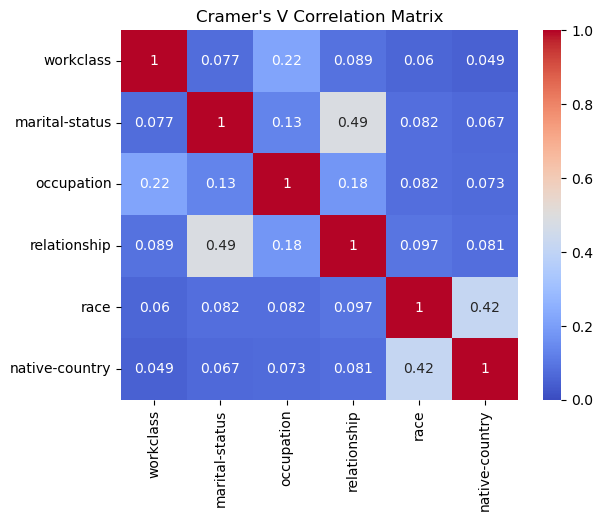

Age:	Low:	0	|	High:	1561
Fnlwgt:	Low:	0	|	High:	1826
Education-num:	Low:	2242	|	High:	544
Hours-per-week:	Low:	1869	|	High:	1527
Capital-delta:	Low:	0	|	High:	365
Training on NORMAL dataset
--------------------------------------
Training: SVC
Train:
Acurracy: 84.92969832992276%
[[21327  1436]
 [ 3130  4405]]

Test:
Acurracy: 84.2736531760922%
[[10504   747]
 [ 1600  2073]]



Training: K-NN
Train:
Acurracy: 86.22351310317514%
[[21549  1214]
 [ 2960  4575]]

Test:
Acurracy: 83.37577057089253%
[[10439   812]
 [ 1669  2004]]



Training: Decision Tree
Train:
Acurracy: 99.99669945210906%
[[22763     0]
 [    1  7534]]

Test:
Acurracy: 80.97024926293219%
[[9728 1523]
 [1317 2356]]



Training: QDA


/usr/lib/python3.13/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/lib/python3.13/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


Train:
Acurracy: 51.3235197042709%
[[ 8312 14451]
 [  297  7238]]

Test:
Acurracy: 50.93808630393997%
[[4085 7166]
 [ 156 3517]]





In [58]:
data = load_clean_data()

train, test = preprocess_data( data )
if INFO:
    print( train.X.shape, test.X.shape )

classifiers = {
    'SVC': { 'model': SVC(gamma='auto'), 'train_conf': None, 'test_conf': None },
    'K-NN': { 'model': KNeighborsClassifier(n_neighbors=10), 'train_conf': None, 'test_conf': None },
    'Decision Tree': { 'model': DecisionTreeClassifier(), 'train_conf': None, 'test_conf': None },
    'QDA': { 'model': QuadraticDiscriminantAnalysis(), 'train_conf': None, 'test_conf': None }
}

print( f"Training on NORMAL dataset" )
print( f"--------------------------------------" )
train_eval( train, test, classifiers )
#visualize( train, classifiers['svc']['model'] )

### Label perturbation
To evaluate the impact of faulty labels in a dataset, we will introduce some errors in the labels of our data.


#### Preparation
Start by creating a method which alters a dataset by selecting a percentage of rows randomly and swaps labels from a 0->1 and 1->0. 


In [129]:

"""Given a label vector, create a new copy where a random fraction of the labels have been flipped."""
def add_errors( y, fraction=0.5 ):
	# Flip fraction*len(data) of the labels in copy
	idx = np.arange( y.shape[0] )
	np.random.shuffle(idx)

	mx_idx = round(fraction*y.shape[0])
	if INFO:
		print( mx_idx )
	idx = idx[:mx_idx]
	y[idx] = y[idx] ^ 1

	return y


In [130]:

## This suggestion seems nonsensical
def perturb( y, mn=10, mx=100 ):
	mn = random.randrange(mn)
	mx = random.randrange(mx)
	if mn > mx:
		tmp = mx
		mx = mn
		mn = tmp
	elif mn == mx:
		mx += 1

	print( f"New range {mn} - {mx}" )
	y = minmax_scale( y, feature_range=( mn, mx ) )
	return y


In [131]:

print( f"\n\nTraining on FLIPPED datasets" )
print( f"--------------------------------------" )
for fraction in range( 1, 7, 2 ):
    print( f"Fraction: {fraction/10}" )
    error_train = DataSet( train.X, add_errors( train.y, fraction=fraction/10 ) )
    train_eval( error_train, test, classifiers )

print( f"\n\nTraining on PERTURBED datasets" )
print( f"--------------------------------------" )
for _ in range( 5 ):
    error_train = DataSet( train.X, perturb( train.y ) )
    train_eval( error_train, test, classifiers )




Training on FLIPPED datasets
--------------------------------------
Fraction: 0.1
Training: SVC
Train:
Acurracy: 77.83021981648953%
[[19755  1530]
 [ 5187  3826]]

Test:
Acurracy: 84.34735995711605%
[[10536   629]
 [ 1707  2052]]



Training: K-NN
Train:
Acurracy: 79.37157568156314%
[[19888  1397]
 [ 4853  4160]]

Test:
Acurracy: 82.83302063789868%
[[10346   819]
 [ 1743  2016]]



Training: Decision Tree
Train:
Acurracy: 99.9867978084362%
[[21285     0]
 [    4  9009]]

Test:
Acurracy: 72.0383275261324%
[[8607 2558]
 [1615 2144]]



Training: QDA
Train:
Acurracy: 74.43065548881114%
[[16991  4294]
 [ 3453  5560]]

Test:
Acurracy: 80.1125703564728%
[[9107 2058]
 [ 910 2849]]



Fraction: 0.3
Training: SVC
Train:
Acurracy: 61.45620172948709%
[[15673  1997]
 [ 9681  2947]]

Test:
Acurracy: 83.06084159742696%
[[10537   628]
 [ 1900  1859]]



Training: K-NN
Train:
Acurracy: 65.72711070037627%
[[15398  2272]
 [ 8112  4516]]

Test:
Acurracy: 74.98659876708658%
[[9501 1664]
 [2069 1690]]




/tmp/ipykernel_4418/3634688526.py:4: RuntimeWarning: invalid value encountered in scalar divide
  accuracy = correct_pred/(correct_pred+false_pred)


Test:
Acurracy: nan%
[[   0    0 5881 5284]
 [   0    0 2355 1404]
 [   0    0    0    0]
 [   0    0    0    0]]



Training: K-NN
Train:
Acurracy: 62.278038154333615%
[[11262  3887]
 [ 7542  7607]]



/tmp/ipykernel_4418/3634688526.py:4: RuntimeWarning: invalid value encountered in scalar divide
  accuracy = correct_pred/(correct_pred+false_pred)


Test:
Acurracy: nan%
[[   0    0 6966 4199]
 [   0    0 2345 1414]
 [   0    0    0    0]
 [   0    0    0    0]]



Training: Decision Tree
Train:
Acurracy: 99.96039342530861%
[[15148     1]
 [   11 15138]]

Test:
Acurracy: nan%
[[   0    0 5580 5585]
 [   0    0 1897 1862]
 [   0    0    0    0]
 [   0    0    0    0]]



Training: QDA
Train:
Acurracy: 52.06944352762558%
[[6138 9011]
 [5511 9638]]

Test:
Acurracy: nan%
[[   0    0 3855 7310]
 [   0    0 1835 1924]
 [   0    0    0    0]
 [   0    0    0    0]]



New range 5 - 98
Training: SVC


/tmp/ipykernel_4418/3634688526.py:4: RuntimeWarning: invalid value encountered in scalar divide
  accuracy = correct_pred/(correct_pred+false_pred)
/tmp/ipykernel_4418/3634688526.py:4: RuntimeWarning: invalid value encountered in scalar divide
  accuracy = correct_pred/(correct_pred+false_pred)


Train:
Acurracy: 53.00679912865536%
[[8797 6352]
 [7886 7263]]



/tmp/ipykernel_4418/3634688526.py:4: RuntimeWarning: invalid value encountered in scalar divide
  accuracy = correct_pred/(correct_pred+false_pred)


Test:
Acurracy: nan%
[[   0    0 5881 5284]
 [   0    0 2355 1404]
 [   0    0    0    0]
 [   0    0    0    0]]



Training: K-NN
Train:
Acurracy: 62.278038154333615%
[[11262  3887]
 [ 7542  7607]]



/tmp/ipykernel_4418/3634688526.py:4: RuntimeWarning: invalid value encountered in scalar divide
  accuracy = correct_pred/(correct_pred+false_pred)


Test:
Acurracy: nan%
[[   0    0 6966 4199]
 [   0    0 2345 1414]
 [   0    0    0    0]
 [   0    0    0    0]]



Training: Decision Tree
Train:
Acurracy: 99.96039342530861%
[[15148     1]
 [   11 15138]]

Test:
Acurracy: nan%
[[   0    0 5593 5572]
 [   0    0 1899 1860]
 [   0    0    0    0]
 [   0    0    0    0]]



Training: QDA
Train:
Acurracy: 52.06944352762558%
[[6138 9011]
 [5511 9638]]

Test:
Acurracy: nan%
[[   0    0 3855 7310]
 [   0    0 1835 1924]
 [   0    0    0    0]
 [   0    0    0    0]]



New range 4 - 81
Training: SVC


/tmp/ipykernel_4418/3634688526.py:4: RuntimeWarning: invalid value encountered in scalar divide
  accuracy = correct_pred/(correct_pred+false_pred)
/tmp/ipykernel_4418/3634688526.py:4: RuntimeWarning: invalid value encountered in scalar divide
  accuracy = correct_pred/(correct_pred+false_pred)


Train:
Acurracy: 53.00679912865536%
[[8797 6352]
 [7886 7263]]



/tmp/ipykernel_4418/3634688526.py:4: RuntimeWarning: invalid value encountered in scalar divide
  accuracy = correct_pred/(correct_pred+false_pred)


Test:
Acurracy: nan%
[[   0    0 5881 5284]
 [   0    0 2355 1404]
 [   0    0    0    0]
 [   0    0    0    0]]



Training: K-NN
Train:
Acurracy: 62.278038154333615%
[[11262  3887]
 [ 7542  7607]]



/tmp/ipykernel_4418/3634688526.py:4: RuntimeWarning: invalid value encountered in scalar divide
  accuracy = correct_pred/(correct_pred+false_pred)


Test:
Acurracy: nan%
[[   0    0 6966 4199]
 [   0    0 2345 1414]
 [   0    0    0    0]
 [   0    0    0    0]]



Training: Decision Tree
Train:
Acurracy: 99.96039342530861%
[[15148     1]
 [   11 15138]]

Test:
Acurracy: nan%
[[   0    0 5610 5555]
 [   0    0 1841 1918]
 [   0    0    0    0]
 [   0    0    0    0]]



Training: QDA
Train:
Acurracy: 52.06944352762558%
[[6138 9011]
 [5511 9638]]

Test:
Acurracy: nan%
[[   0    0 3855 7310]
 [   0    0 1835 1924]
 [   0    0    0    0]
 [   0    0    0    0]]



New range 7 - 68
Training: SVC


/tmp/ipykernel_4418/3634688526.py:4: RuntimeWarning: invalid value encountered in scalar divide
  accuracy = correct_pred/(correct_pred+false_pred)
/tmp/ipykernel_4418/3634688526.py:4: RuntimeWarning: invalid value encountered in scalar divide
  accuracy = correct_pred/(correct_pred+false_pred)


Train:
Acurracy: 53.00679912865536%
[[8797 6352]
 [7886 7263]]



/tmp/ipykernel_4418/3634688526.py:4: RuntimeWarning: invalid value encountered in scalar divide
  accuracy = correct_pred/(correct_pred+false_pred)


Test:
Acurracy: nan%
[[   0    0 5881 5284]
 [   0    0 2355 1404]
 [   0    0    0    0]
 [   0    0    0    0]]



Training: K-NN
Train:
Acurracy: 62.278038154333615%
[[11262  3887]
 [ 7542  7607]]



/tmp/ipykernel_4418/3634688526.py:4: RuntimeWarning: invalid value encountered in scalar divide
  accuracy = correct_pred/(correct_pred+false_pred)


Test:
Acurracy: nan%
[[   0    0 6966 4199]
 [   0    0 2345 1414]
 [   0    0    0    0]
 [   0    0    0    0]]



Training: Decision Tree
Train:
Acurracy: 99.96039342530861%
[[15148     1]
 [   11 15138]]

Test:
Acurracy: nan%
[[   0    0 5577 5588]
 [   0    0 1892 1867]
 [   0    0    0    0]
 [   0    0    0    0]]



Training: QDA
Train:
Acurracy: 52.06944352762558%
[[6138 9011]
 [5511 9638]]

Test:
Acurracy: nan%
[[   0    0 3855 7310]
 [   0    0 1835 1924]
 [   0    0    0    0]
 [   0    0    0    0]]



New range 3 - 11
Training: SVC


/tmp/ipykernel_4418/3634688526.py:4: RuntimeWarning: invalid value encountered in scalar divide
  accuracy = correct_pred/(correct_pred+false_pred)
/tmp/ipykernel_4418/3634688526.py:4: RuntimeWarning: invalid value encountered in scalar divide
  accuracy = correct_pred/(correct_pred+false_pred)


Train:
Acurracy: 53.00679912865536%
[[8797 6352]
 [7886 7263]]



/tmp/ipykernel_4418/3634688526.py:4: RuntimeWarning: invalid value encountered in scalar divide
  accuracy = correct_pred/(correct_pred+false_pred)


Test:
Acurracy: nan%
[[   0    0 5881 5284]
 [   0    0 2355 1404]
 [   0    0    0    0]
 [   0    0    0    0]]



Training: K-NN
Train:
Acurracy: 62.278038154333615%
[[11262  3887]
 [ 7542  7607]]



/tmp/ipykernel_4418/3634688526.py:4: RuntimeWarning: invalid value encountered in scalar divide
  accuracy = correct_pred/(correct_pred+false_pred)


Test:
Acurracy: nan%
[[   0    0 6966 4199]
 [   0    0 2345 1414]
 [   0    0    0    0]
 [   0    0    0    0]]



Training: Decision Tree
Train:
Acurracy: 99.96039342530861%
[[15148     1]
 [   11 15138]]

Test:
Acurracy: nan%
[[   0    0 5644 5521]
 [   0    0 1876 1883]
 [   0    0    0    0]
 [   0    0    0    0]]



Training: QDA
Train:
Acurracy: 52.06944352762558%
[[6138 9011]
 [5511 9638]]

Test:
Acurracy: nan%
[[   0    0 3855 7310]
 [   0    0 1835 1924]
 [   0    0    0    0]
 [   0    0    0    0]]





/tmp/ipykernel_4418/3634688526.py:4: RuntimeWarning: invalid value encountered in scalar divide
  accuracy = correct_pred/(correct_pred+false_pred)
/tmp/ipykernel_4418/3634688526.py:4: RuntimeWarning: invalid value encountered in scalar divide
  accuracy = correct_pred/(correct_pred+false_pred)


#### Analysis
Create a number of new datasets with perturbed labels, for fractions ranging from `0` to `0.5` in increments of `0.1`.

Perform the same experiment you did before, which compared the performances of different models except with the new datasets. Repeat your experiment at least 5x for each model and perturbation level and calculate the mean and variance of the scores. Visualize the change in score for different perturbation levels for all of the models in a single plot. 

State your observations. Is there a change in the performance of the models? Are there some classifiers which are impacted more/less than other classifiers and why is this the case?

In [ ]:
# Code

Observations + explanations: max. 400 words

#### Discussion

1)  Discuss how you could reduce the impact of wrongly labeled data or correct wrong labels. <br />
    max. 400 words



    Authors: Youri Arkesteijn, Tim van der Horst and Kevin Chong.


## Machine Learning Workflow

From part 1, you will have gone through the entire machine learning workflow which are they following steps:

1) Data Loading
2) Data Pre-processing
3) Machine Learning Model Training
4) Machine Learning Model Testing

You can see these tasks are very sequential, and need to be done in a serial fashion. 

As a small perturbation in the actions performed in each of the steps may have a detrimental knock-on effect in the task that comes afterwards.

In the final part of Part 1, you will have experienced the effects of performing perturbations to the machine learning model training aspect and the reaction of the machine learning model testing section.

## Part 2 Data Discovery

You will be given a set of datasets and you are tasked to perform data discovery on the data sets.

<b>The datasets are provided in the group lockers on brightspace. Let me know if you are having trouble accessing the datasets</b>

The process is to have the goal of finding datasets that are related to each other, finding relationships between the datasets.

The relationships that we are primarily working with are Join and Union relationships.

So please implement two methods for allowing us to find those pesky Join and Union relationships.

Try to do this with the datasets as is and no processing.



In [ ]:
def discovery_algorithm():
    """Function should be able to perform data discovery to find related datasets
    Possible Input: List of datasets
    Output: List of pairs of related datasets
    """

    pass

You would have noticed that the data has some issues in them.
So perhaps those issues have been troublesome to deal with.

Please try to do some cleaning on the data.

After performing cleaning see if the results of the data discovery has changed?

Please try to explain this in your report, and try to match up the error with the observation.

In [ ]:
## Cleaning data, scrubbing, washing, mopping

def cleaningData(data):
    """Function should be able to clean the data
    Possible Input: List of datasets
    Output: List of cleaned datasets
    """

    pass

## Discussions

1)  Different aspects of the data can effect the data discovery process. Write a short report on your findings. Such as which data quality issues had the largest effect on data discovery. Which data quality problem was repairable and how you choose to do the repair.

<!-- For the set of considerations that you have outlined for the choice of data discovery methods, choose one and identify under this new constraint, how would you identify and resolve this problem? -->

Max 400 words